In [1]:
import sys
import os
import warnings
import cv2 as cv
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn.metrics
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from PIL import Image

# Import required libraries

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def print_metrics(test_generator, model):

  preds = model.predict(test_generator, verbose=1)

  Y_pred = np.argmax(preds, axis=1)
  Y_true = test_generator.classes
    
  test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
  print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
  print(f'Test Loss: {test_loss:.2f}%')
    
  
  print(classification_report(Y_true, Y_pred, digits=3))

  cm = confusion_matrix(Y_true, Y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  return

In [3]:
def plot_performance(metric1, metric2, title):
  plt.plot(list(range(len(metric1))), metric1, color='blue', label='Train', linestyle='-')
  plt.plot(list(range(len(metric2))), metric2, color='red', label='Val', linestyle='--')
  plt.title(title)
  plt.xlabel('Iterations')
  plt.legend()
  return

In [4]:
test_or = '/kaggle/input/test-original/test/test'

In [5]:
train_or = '/kaggle/input/train-or/train/train'

In [6]:
train_gen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
)
test_gen = ImageDataGenerator(rescale=1./255)
print("\nTraining set:\n")
train_generator = train_gen.flow_from_directory(
    train_or,
    target_size=(96,96),
    batch_size=256,
    class_mode='categorical',
    subset='training',
    shuffle = True
)
print("\nValidation set:\n")
val_generator = train_gen.flow_from_directory(
    train_or,
    target_size=(96,96),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
)
print("\nTest set:\n")
test_generator = test_gen.flow_from_directory(
    test_or,
    target_size=(96, 96),
    batch_size=1,
    class_mode='categorical',
    shuffle = False
)


Training set:

Found 5096 images belonging to 5 classes.

Validation set:

Found 1273 images belonging to 5 classes.

Test set:

Found 2749 images belonging to 5 classes.


In [8]:
train_gen_aug = ImageDataGenerator(
    rescale=1/255,
    #zoom_range=0.6,
    brightness_range=[0.75, 1.25],
    vertical_flip = True,
    horizontal_flip = True,
    validation_split=0.2,
)
test_gen_aug = ImageDataGenerator(rescale=1./255)

print("\nTraining set:\n")
train_generator_aug = train_gen_aug.flow_from_directory(
    train_or,
    target_size=(96,96),
    batch_size=256,
    class_mode='categorical',
    subset='training',
    shuffle = True
)
print("\nValidation set:\n")
val_generator_aug = train_gen_aug.flow_from_directory(
    train_or,
    target_size=(96,96),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle = False
)
print("\nTest set:\n")
test_generator_aug = test_gen_aug.flow_from_directory(
    test_or,
    target_size=(96, 96),
    batch_size=1,
    class_mode='categorical',
    shuffle = False
)


Training set:

Found 5096 images belonging to 5 classes.

Validation set:

Found 1273 images belonging to 5 classes.

Test set:

Found 2749 images belonging to 5 classes.


# Model 1: Drop Out

In [9]:
# design CNN with regularization terms

model1 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation='relu', input_shape=(96,96,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ]
)

model1.summary()
# check loss and optimizer
model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history1 = model1.fit(train_generator, epochs=30, validation_data=val_generator)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

In [10]:
train_loss1 = history1.history['loss']
train_accuracy1 = history1.history['accuracy']
val_loss1 = history1.history['val_loss']
val_accuracy1 = history1.history['val_accuracy']

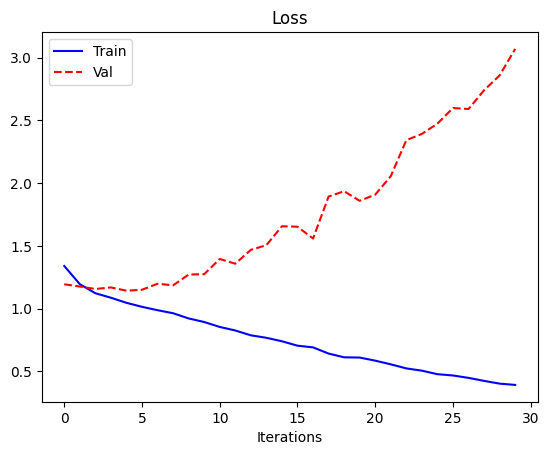

In [11]:
plot_performance(train_loss1, val_loss1, 'Loss')

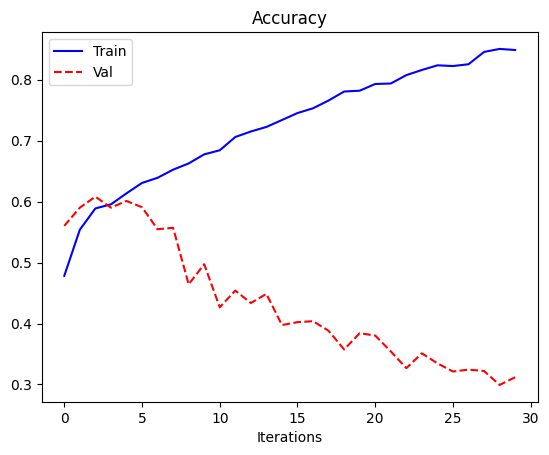

In [12]:
plot_performance(train_accuracy1, val_accuracy1, 'Accuracy')

2749/2749 [==============================] - 9s 3ms/step - loss: 2.5453 - accuracy: 0.4893
Test Accuracy: 48.93%
Test Loss: 2.55%
              precision    recall  f1-score   support

           0      0.144     0.376     0.208       133
           1      0.289     0.618     0.394       275
           2      0.407     0.682     0.510       406
           3      0.864     0.444     0.586      1896
           4      0.044     0.179     0.071        39

    accuracy                          0.489      2749
   macro avg      0.350     0.460     0.354      2749
weighted avg      0.693     0.489     0.530      2749



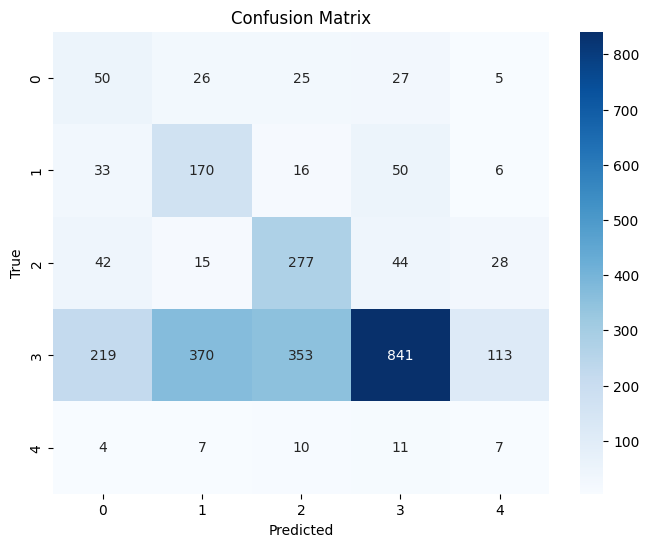

In [13]:
print_metrics(test_generator, model1)

# Model 2: Drop Out and Early stopping

In [14]:
model2 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation='relu', input_shape=(96,96,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ]
)

model2.summary()
# check loss and optimizer
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = model2.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 128)      

In [15]:
train_loss2 = history2.history['loss']
train_accuracy2 = history2.history['accuracy']
val_loss2 = history2.history['val_loss']
val_accuracy2 = history2.history['val_accuracy']


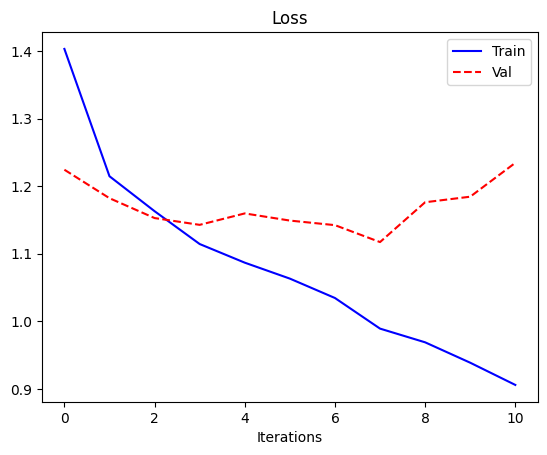

In [16]:
plot_performance(train_loss2, val_loss2, 'Loss')

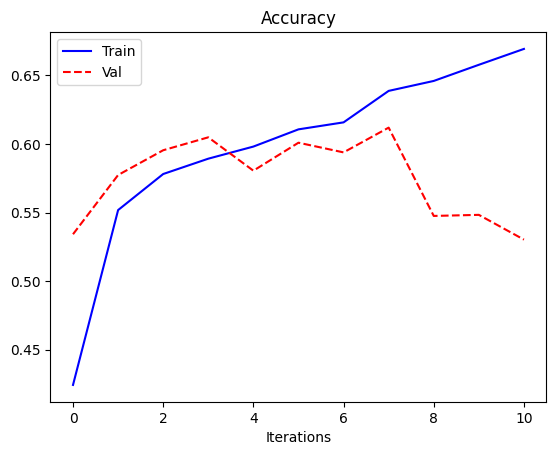

In [17]:
plot_performance(train_accuracy2, val_accuracy2, 'Accuracy')


2749/2749 [==============================] - 9s 3ms/step - loss: 0.9927 - accuracy: 0.6581
Test Accuracy: 65.81%
Test Loss: 0.99%
              precision    recall  f1-score   support

           0      0.345     0.383     0.363       133
           1      0.356     0.549     0.432       275
           2      0.476     0.695     0.565       406
           3      0.849     0.698     0.766      1896
           4      0.080     0.051     0.062        39

    accuracy                          0.658      2749
   macro avg      0.421     0.475     0.438      2749
weighted avg      0.709     0.658     0.673      2749



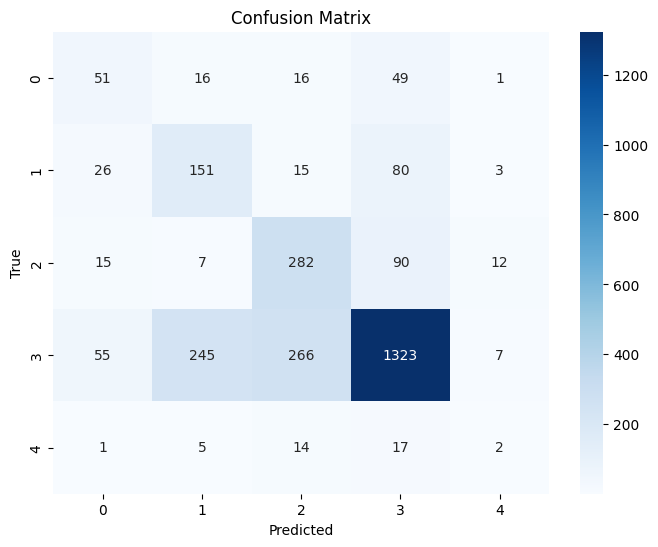

In [18]:
print_metrics(test_generator, model2)

# Model 3: Shallower Network

In [19]:
model3 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation='relu', input_shape=(96,96,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ]
)

model3.summary()
# check loss and optimizer
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history3 = model3.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 30976)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [20]:
train_loss3 = history3.history['loss']
train_accuracy3 = history3.history['accuracy']
val_loss3 = history3.history['val_loss']
val_accuracy3 = history3.history['val_accuracy']

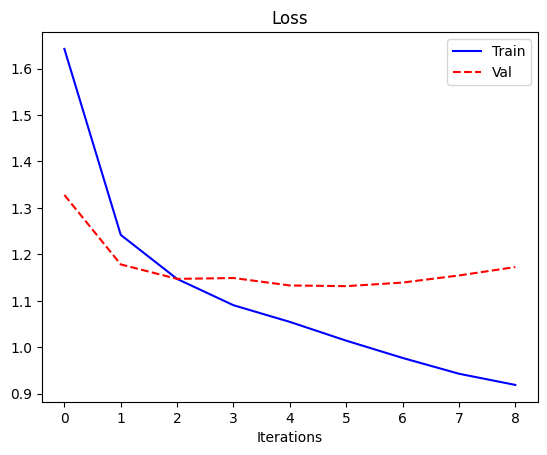

In [21]:
plot_performance(train_loss3, val_loss3, 'Loss')

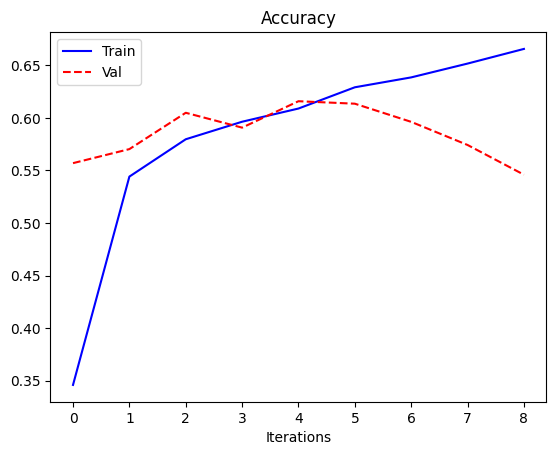

In [22]:
plot_performance(train_accuracy3, val_accuracy3, 'Accuracy')

2749/2749 [==============================] - 9s 3ms/step - loss: 1.0600 - accuracy: 0.6322
Test Accuracy: 63.22%
Test Loss: 1.06%
              precision    recall  f1-score   support

           0      0.314     0.444     0.368       133
           1      0.343     0.578     0.430       275
           2      0.449     0.732     0.557       406
           3      0.865     0.643     0.738      1896
           4      0.115     0.077     0.092        39

    accuracy                          0.632      2749
   macro avg      0.417     0.495     0.437      2749
weighted avg      0.714     0.632     0.653      2749



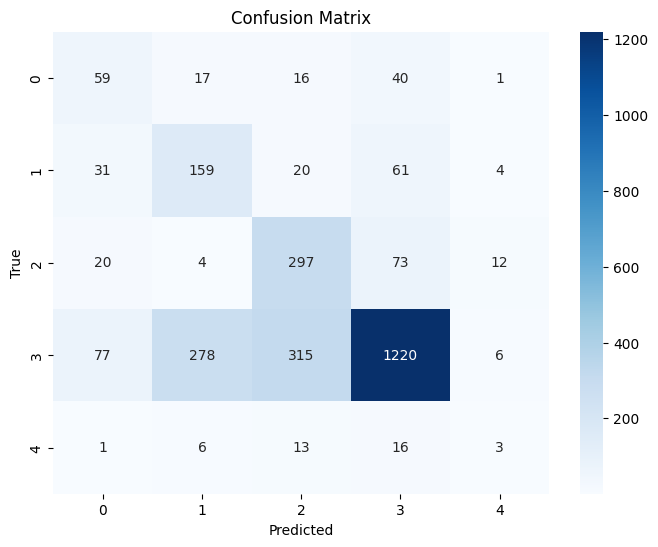

In [23]:
print_metrics(test_generator, model3)

# Model 4: Data Augmentation, Drop Out, Early Stopping and Shallower Network

In [24]:
train_gen_aug = ImageDataGenerator(
    rescale=1/255,
    #zoom_range=0.6,
    brightness_range=[0.75, 1.25],
    vertical_flip = True,
    horizontal_flip = True,
    validation_split=0.2,
)
test_gen_aug = ImageDataGenerator(rescale=1./255)

print("\nTraining set:\n")
train_generator_aug = train_gen_aug.flow_from_directory(
    train_or,
    target_size=(96,96),
    batch_size=256,
    class_mode='categorical',
    subset='training',
    shuffle = True
)
print("\nValidation set:\n")
val_generator_aug = train_gen_aug.flow_from_directory(
    train_or,
    target_size=(96,96),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle = False
)
print("\nTest set:\n")
test_generator_aug = test_gen_aug.flow_from_directory(
    test_or,
    target_size=(96, 96),
    batch_size=1,
    class_mode='categorical',
    shuffle = False
)


Training set:

Found 5096 images belonging to 5 classes.

Validation set:

Found 1273 images belonging to 5 classes.

Test set:

Found 2749 images belonging to 5 classes.


In [25]:
# design CNN with regularization terms

model_aug = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation='relu', input_shape=(96,96,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ]
)

model_aug.summary()

# changed lr optimizer SGD and 0.01 but stucked
model_aug.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 30976)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [27]:
history_aug = model_aug.fit(train_generator_aug, epochs=30, validation_data=val_generator_aug, callbacks=[early_stopping])

Epoch 1/30
20/20 [==============================] - 13s 536ms/step - loss: 1.9017 - accuracy: 0.2853 - val_loss: 1.5369 - val_accuracy: 0.3142
Epoch 2/30
20/20 [==============================] - 11s 568ms/step - loss: 1.4793 - accuracy: 0.3738 - val_loss: 1.3852 - val_accuracy: 0.4933
Epoch 3/30
20/20 [==============================] - 12s 583ms/step - loss: 1.3899 - accuracy: 0.4715 - val_loss: 1.3168 - val_accuracy: 0.5318
Epoch 4/30
20/20 [==============================] - 11s 566ms/step - loss: 1.3226 - accuracy: 0.5069 - val_loss: 1.2807 - val_accuracy: 0.5436
Epoch 5/30
20/20 [==============================] - 12s 586ms/step - loss: 1.2873 - accuracy: 0.5300 - val_loss: 1.2810 - val_accuracy: 0.5475
Epoch 6/30
20/20 [==============================] - 11s 575ms/step - loss: 1.2675 - accuracy: 0.5347 - val_loss: 1.2684 - val_accuracy: 0.5609
Epoch 7/30
20/20 [==============================] - 11s 557ms/step - loss: 1.2430 - accuracy: 0.5457 - val_loss: 1.2475 - val_accuracy: 0.5632

In [28]:
train_loss_aug = history_aug.history['loss']
train_accuracy_aug = history_aug.history['accuracy']
val_loss_aug = history_aug.history['val_loss']
val_accuracy_aug = history_aug.history['val_accuracy']

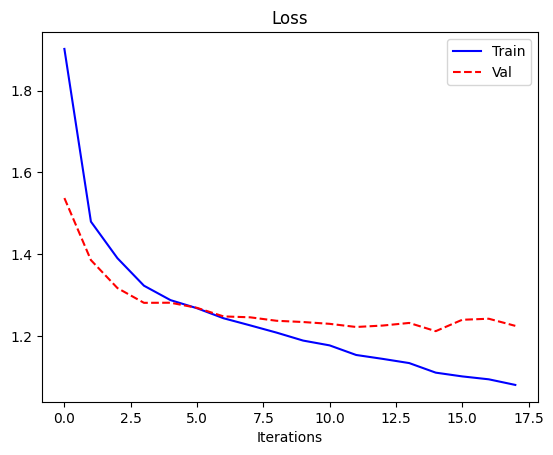

In [29]:
plot_performance(train_loss_aug, val_loss_aug, 'Loss')

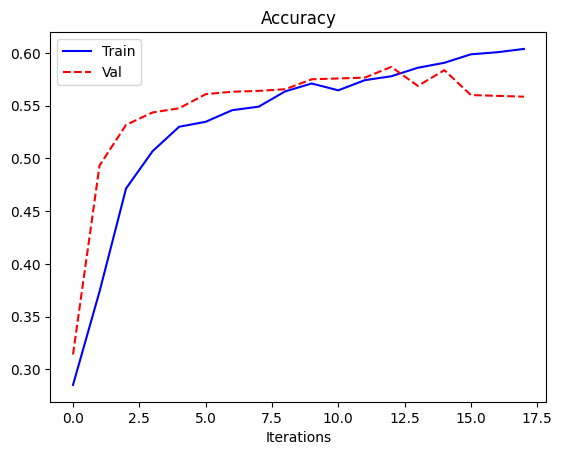

In [30]:
plot_performance(train_accuracy_aug, val_accuracy_aug, 'Accuracy')

2749/2749 [==============================] - 9s 3ms/step - loss: 1.0270 - accuracy: 0.6901
Test Accuracy: 69.01%
Test Loss: 1.03%
              precision    recall  f1-score   support

           0      0.376     0.398     0.387       133
           1      0.367     0.542     0.438       275
           2      0.520     0.638     0.573       406
           3      0.846     0.757     0.799      1896
           4      0.000     0.000     0.000        39

    accuracy                          0.690      2749
   macro avg      0.422     0.467     0.439      2749
weighted avg      0.715     0.690     0.698      2749



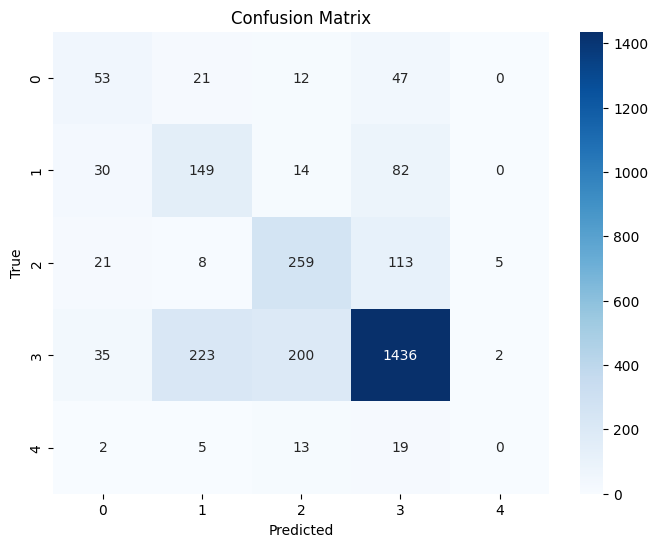

In [31]:
print_metrics(test_generator_aug, model_aug)

New model with different data augmentation techniques

In [32]:
train_gen_aug_2 = ImageDataGenerator(
    rescale=1/255,
    zoom_range=0.6,
    brightness_range=[0.75, 1.25],
    #vertical_flip = True,
    #horizontal_flip = True,
    validation_split=0.2,
)
test_gen_aug_2 = ImageDataGenerator(rescale=1./255)

print("\nTraining set:\n")
train_generator_aug_2 = train_gen_aug.flow_from_directory(
    train_or,
    target_size=(96,96),
    batch_size=256,
    class_mode='categorical',
    subset='training',
    shuffle = True
)
print("\nValidation set:\n")
val_generator_aug_2 = train_gen_aug.flow_from_directory(
    train_or,
    target_size=(96,96),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle = False
)
print("\nTest set:\n")
test_generator_aug_2 = test_gen_aug.flow_from_directory(
    test_or,
    target_size=(96, 96),
    batch_size=1,
    class_mode='categorical',
    shuffle = False
)


Training set:

Found 5096 images belonging to 5 classes.

Validation set:

Found 1273 images belonging to 5 classes.

Test set:

Found 2749 images belonging to 5 classes.


In [33]:
# same architecture different LR

model_aug = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation='relu', input_shape=(96,96,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ]
)

model_aug.summary()

# changed lr optimizer SGD and 0.01 but stucked
model_aug.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 30976)             0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [34]:
history_aug_2 = model_aug.fit(train_generator_aug_2, epochs=30, validation_data=val_generator_aug_2, callbacks=[early_stopping])

Epoch 1/30
20/20 [==============================] - 13s 577ms/step - loss: 1.5775 - accuracy: 0.3326 - val_loss: 1.4185 - val_accuracy: 0.5137
Epoch 2/30
20/20 [==============================] - 12s 578ms/step - loss: 1.3753 - accuracy: 0.4792 - val_loss: 1.2776 - val_accuracy: 0.5460
Epoch 3/30
20/20 [==============================] - 11s 571ms/step - loss: 1.3089 - accuracy: 0.5175 - val_loss: 1.2699 - val_accuracy: 0.5460
Epoch 4/30
20/20 [==============================] - 12s 610ms/step - loss: 1.2698 - accuracy: 0.5279 - val_loss: 1.2544 - val_accuracy: 0.5554
Epoch 5/30
20/20 [==============================] - 12s 597ms/step - loss: 1.2395 - accuracy: 0.5467 - val_loss: 1.2416 - val_accuracy: 0.5617
Epoch 6/30
20/20 [==============================] - 12s 611ms/step - loss: 1.2048 - accuracy: 0.5563 - val_loss: 1.2196 - val_accuracy: 0.5711
Epoch 7/30
20/20 [==============================] - 11s 566ms/step - loss: 1.1729 - accuracy: 0.5636 - val_loss: 1.2257 - val_accuracy: 0.5679

In [36]:
train_loss_aug_2 = history_aug_2.history['loss']
train_accuracy_aug_2 = history_aug_2.history['accuracy']
val_loss_aug_2 = history_aug_2.history['val_loss']
val_accuracy_aug_2 = history_aug_2.history['val_accuracy']

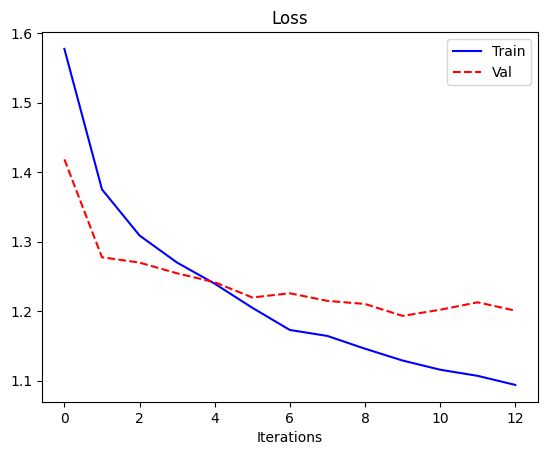

In [37]:
plot_performance(train_loss_aug_2, val_loss_aug_2, 'Loss')

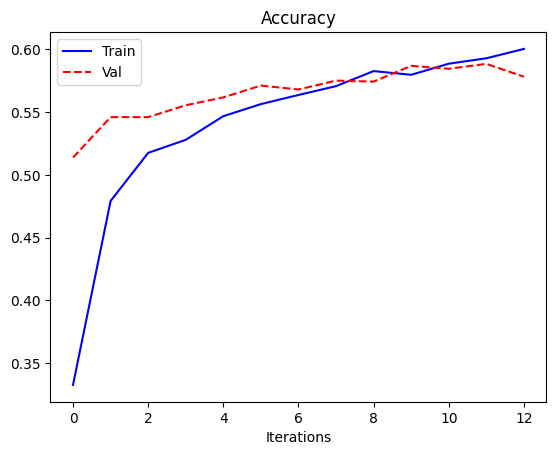

In [38]:
plot_performance(train_accuracy_aug_2, val_accuracy_aug_2, 'Accuracy')

2749/2749 [==============================] - 9s 3ms/step - loss: 1.0418 - accuracy: 0.6784
Test Accuracy: 67.84%
Test Loss: 1.04%
              precision    recall  f1-score   support

           0      0.380     0.368     0.374       133
           1      0.356     0.520     0.422       275
           2      0.491     0.658     0.562       406
           3      0.840     0.742     0.788      1896
           4      0.000     0.000     0.000        39

    accuracy                          0.678      2749
   macro avg      0.413     0.458     0.429      2749
weighted avg      0.706     0.678     0.687      2749



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


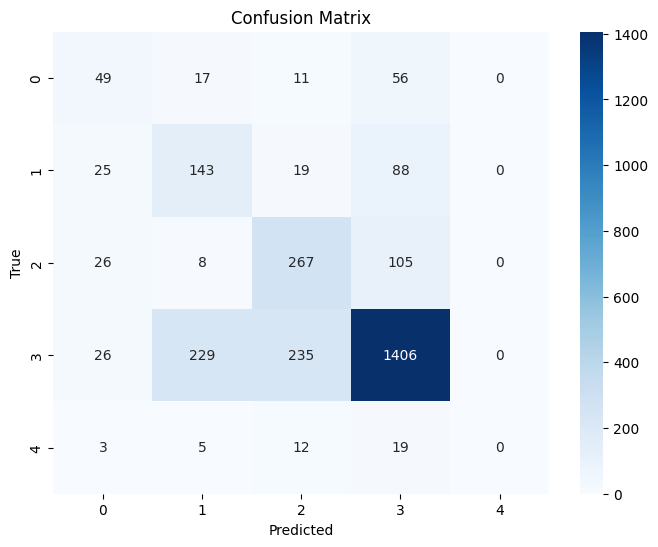

In [39]:
print_metrics(test_generator_aug_2, model_aug)

In [ ]:
!pip install gym

In [ ]:
!pip install gym

In [ ]:
!pip install box2d-py

In [ ]:
import sys

try:
    import gym
except ModuleNotFoundError:
    print('gymnasium module not found. Try to install with')
    print('pip install gymnasium[box2d]')
    sys.exit(1)


def play(env, model):

    seed = 2000
    obs = env.reset(seed=seed)

    # drop initial frames
    action0 = 0
    for i in range(50):
        obs,_,_,_ = env.step(action0)

    done = False
    while not done:
        obs = np.expand_dims(obs, axis = 0)
        p = model.predict(obs) # adapt to your model
        action = np.argmax(p)  # adapt to your model
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated




env_arguments = {
    'domain_randomize': False,
    'continuous': False,
    'render_mode': 'human'
}

env_name = 'CarRacing-v2'
env = gym.make(env_name, **env_arguments)

print("Environment:", env_name)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

# your trained

play(env, model_aug)
